In [5]:
import wandb
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

# initialize wandb
wandb.init(project='wandb-test-loss')
# evaluate the training loss
"""
Adapted from
https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

A simple implementation of Gaussian MLP Encoder and Decoder trained on MNIST
"""

# Model Hyperparameters
dataset_path = 'datasets'
cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 100
x_dim  = 784
hidden_dim = 400
latent_dim = 20
lr = 1e-3
epochs = 5


# Data loading
mnist_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

class Encoder(nn.Module):  
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        self.training = True
        
    def forward(self, x):
        h_       = torch.relu(self.FC_input(x))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     
                                                      
        std      = torch.exp(0.5*log_var)             
        z        = self.reparameterization(mean, std)
        
        return z, mean, log_var
       
    def reparameterization(self, mean, std,):
        epsilon = torch.randn_like(std)
        
        z = mean + std*epsilon
        
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h     = torch.relu(self.FC_hidden(x))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
    
    
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
                
    def forward(self, x):
        z, mean, log_var = self.Encoder(x)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var
    
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)


In [17]:
print("Start training VAE...")
epochs=3
model.train()
average_losses = []
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        # log overall loss to wandb
        # wandb.log({"loss":loss}) #, commit=False)   
        
        loss.backward()
        optimizer.step()
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))    
    # average_loss = (overall_loss / (batch_idx*batch_size))
    average_losses.append(overall_loss / (batch_idx*batch_size))
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  106.72890655976106
	Epoch 2 complete! 	Average Loss:  106.3687057041684
	Epoch 3 complete! 	Average Loss:  105.99421297866236
Finish!!


In [18]:
average_losses

[106.72890655976106, 106.3687057041684, 105.99421297866236]

In [25]:
x=[1,2,3]

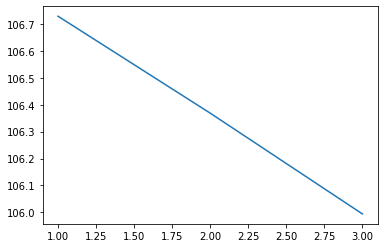

In [28]:
plt.plot(x,average_losses)

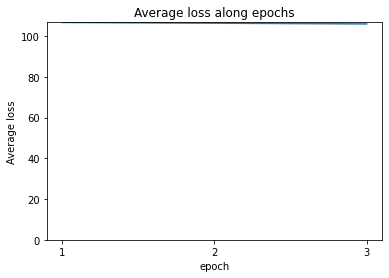

In [39]:
x = [1,2,3,4,5]
plt.plot(x,average_losses)
plt.title('Average loss along epochs')
plt.xlabel('epoch')
plt.ylabel('Average loss')
plt.locator_params(axis="both", integer=True, tight=True)
plt.ylim(ymin=0)
plt.show()
wandb.log({"Average_loss": plt}) #, commit=False)


In [ ]:

# Generate reconstructions
model.eval()
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(test_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)      
        x_hat, _, _ = model(x)       
        break

save_image(x.view(batch_size, 1, 28, 28), 'orig_data.png')
save_image(x_hat.view(batch_size, 1, 28, 28), 'reconstructions.png')

wandb.log({"orig_data": wandb.Image("orig_data.png")}) #, commit=False)
wandb.log({"reconstruction": wandb.Image("reconstructions.png")}) #, commit=False)


wandb.finish()

In [4]:
wandb.init(project='wandb-test-loss')
x = [1,2,3,4,5]
y = [10,20,30,20,70]
data = [[x, y]]
# table = wandb.Table(data=data, columns = ["x", "y"])
wandb.log({"my_custom_plot_id" : wandb.plot.line(x,y,
           title="Custom Y vs X Line Plot")})

TypeError: line() missing 1 required positional argument: 'y'

wandb: Currently logged in as: alaym3 (dtu_ml_ops). Use `wandb login --relogin` to force relogin


Start training VAE...
	Epoch 1 complete! 	Average Loss:  157.63877253104133
	Epoch 2 complete! 	Average Loss:  119.56995448142737
Finish!!


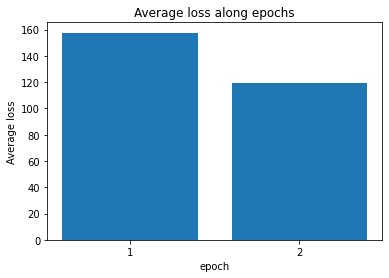

ValueError: min() arg is an empty sequence

In [1]:
import wandb
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

# initialize wandb
wandb.init(project='wandb-test-loss')
# evaluate the training loss
"""
Adapted from
https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

A simple implementation of Gaussian MLP Encoder and Decoder trained on MNIST
"""

# Model Hyperparameters
dataset_path = 'datasets'
cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 100
x_dim  = 784
hidden_dim = 400
latent_dim = 20
lr = 1e-3
epochs = 2


# Data loading
mnist_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

class Encoder(nn.Module):  
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        self.training = True
        
    def forward(self, x):
        h_       = torch.relu(self.FC_input(x))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     
                                                      
        std      = torch.exp(0.5*log_var)             
        z        = self.reparameterization(mean, std)
        
        return z, mean, log_var
       
    def reparameterization(self, mean, std,):
        epsilon = torch.randn_like(std)
        
        z = mean + std*epsilon
        
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h     = torch.relu(self.FC_hidden(x))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
    
    
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
                
    def forward(self, x):
        z, mean, log_var = self.Encoder(x)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var
    
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)


print("Start training VAE...")
model.train()
average_losses=[]
for epoch in range(epochs):
    overall_loss = 0
    average_loss = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        # log overall loss to wandb
        wandb.log({"loss":loss}) #, commit=False)   
        
        loss.backward()
        optimizer.step()
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))    
    average_losses.append(overall_loss / (batch_idx*batch_size))
print("Finish!!")
x = [1,2] #,3,4,5]
plt.bar(x,average_losses)
plt.title('Average loss along epochs')
plt.xlabel('epoch')
plt.ylabel('Average loss')
plt.locator_params(axis="both", integer=True, tight=True)
# plt.ylim(bottom=0)
plt.show()
wandb.log({"Average_loss": plt}) #, commit=False)

# wandb.log({"Average_loss": plt}) #, commit=False)

# Generate reconstructions
model.eval()
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(test_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)      
        x_hat, _, _ = model(x)       
        break

# save_image(x.view(batch_size, 1, 28, 28), 'orig_data.png')
# save_image(x_hat.view(batch_size, 1, 28, 28), 'reconstructions.png')

wandb.log({"orig_data": wandb.Image("orig_data.png")}) #, commit=False)
wandb.log({"reconstruction": wandb.Image("reconstructions.png")}) #, commit=False)


wandb.finish()